## ⚙️ Import Libraries

In [1]:
#IMPORT LIBRARIES

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load the Data

In [2]:
data = np.load('/kaggle/input/aiutoo/mars_for_students.npz')

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

x_test_ev = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {x_test_ev.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [3]:
category_map = {0: 0, # background
           1: 1,  # soil
           2: 2,  # bedrock
           3: 3,  # sand
           4: 4  # big rock
}

In [4]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [5]:
def display_color_mapped_image_continuous(image, n_colors=5):
    """
    Display an image with colors mapped from a given image array using a continuous colormap.
    The image array should contain integer values from 0 to n_colors-1, where each integer
    represents a different color sampled linearly from the colormap.

    Args:
    image (ndarray): An array of shape (H, W) containing integer values from 0 to n_colors-1.
    n_colors (int): The number of colors to use from the colormap. Max 5.
    """
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_colors))

    # Map the colors
    colored_image = colors[image.astype(int)]

    return colored_image

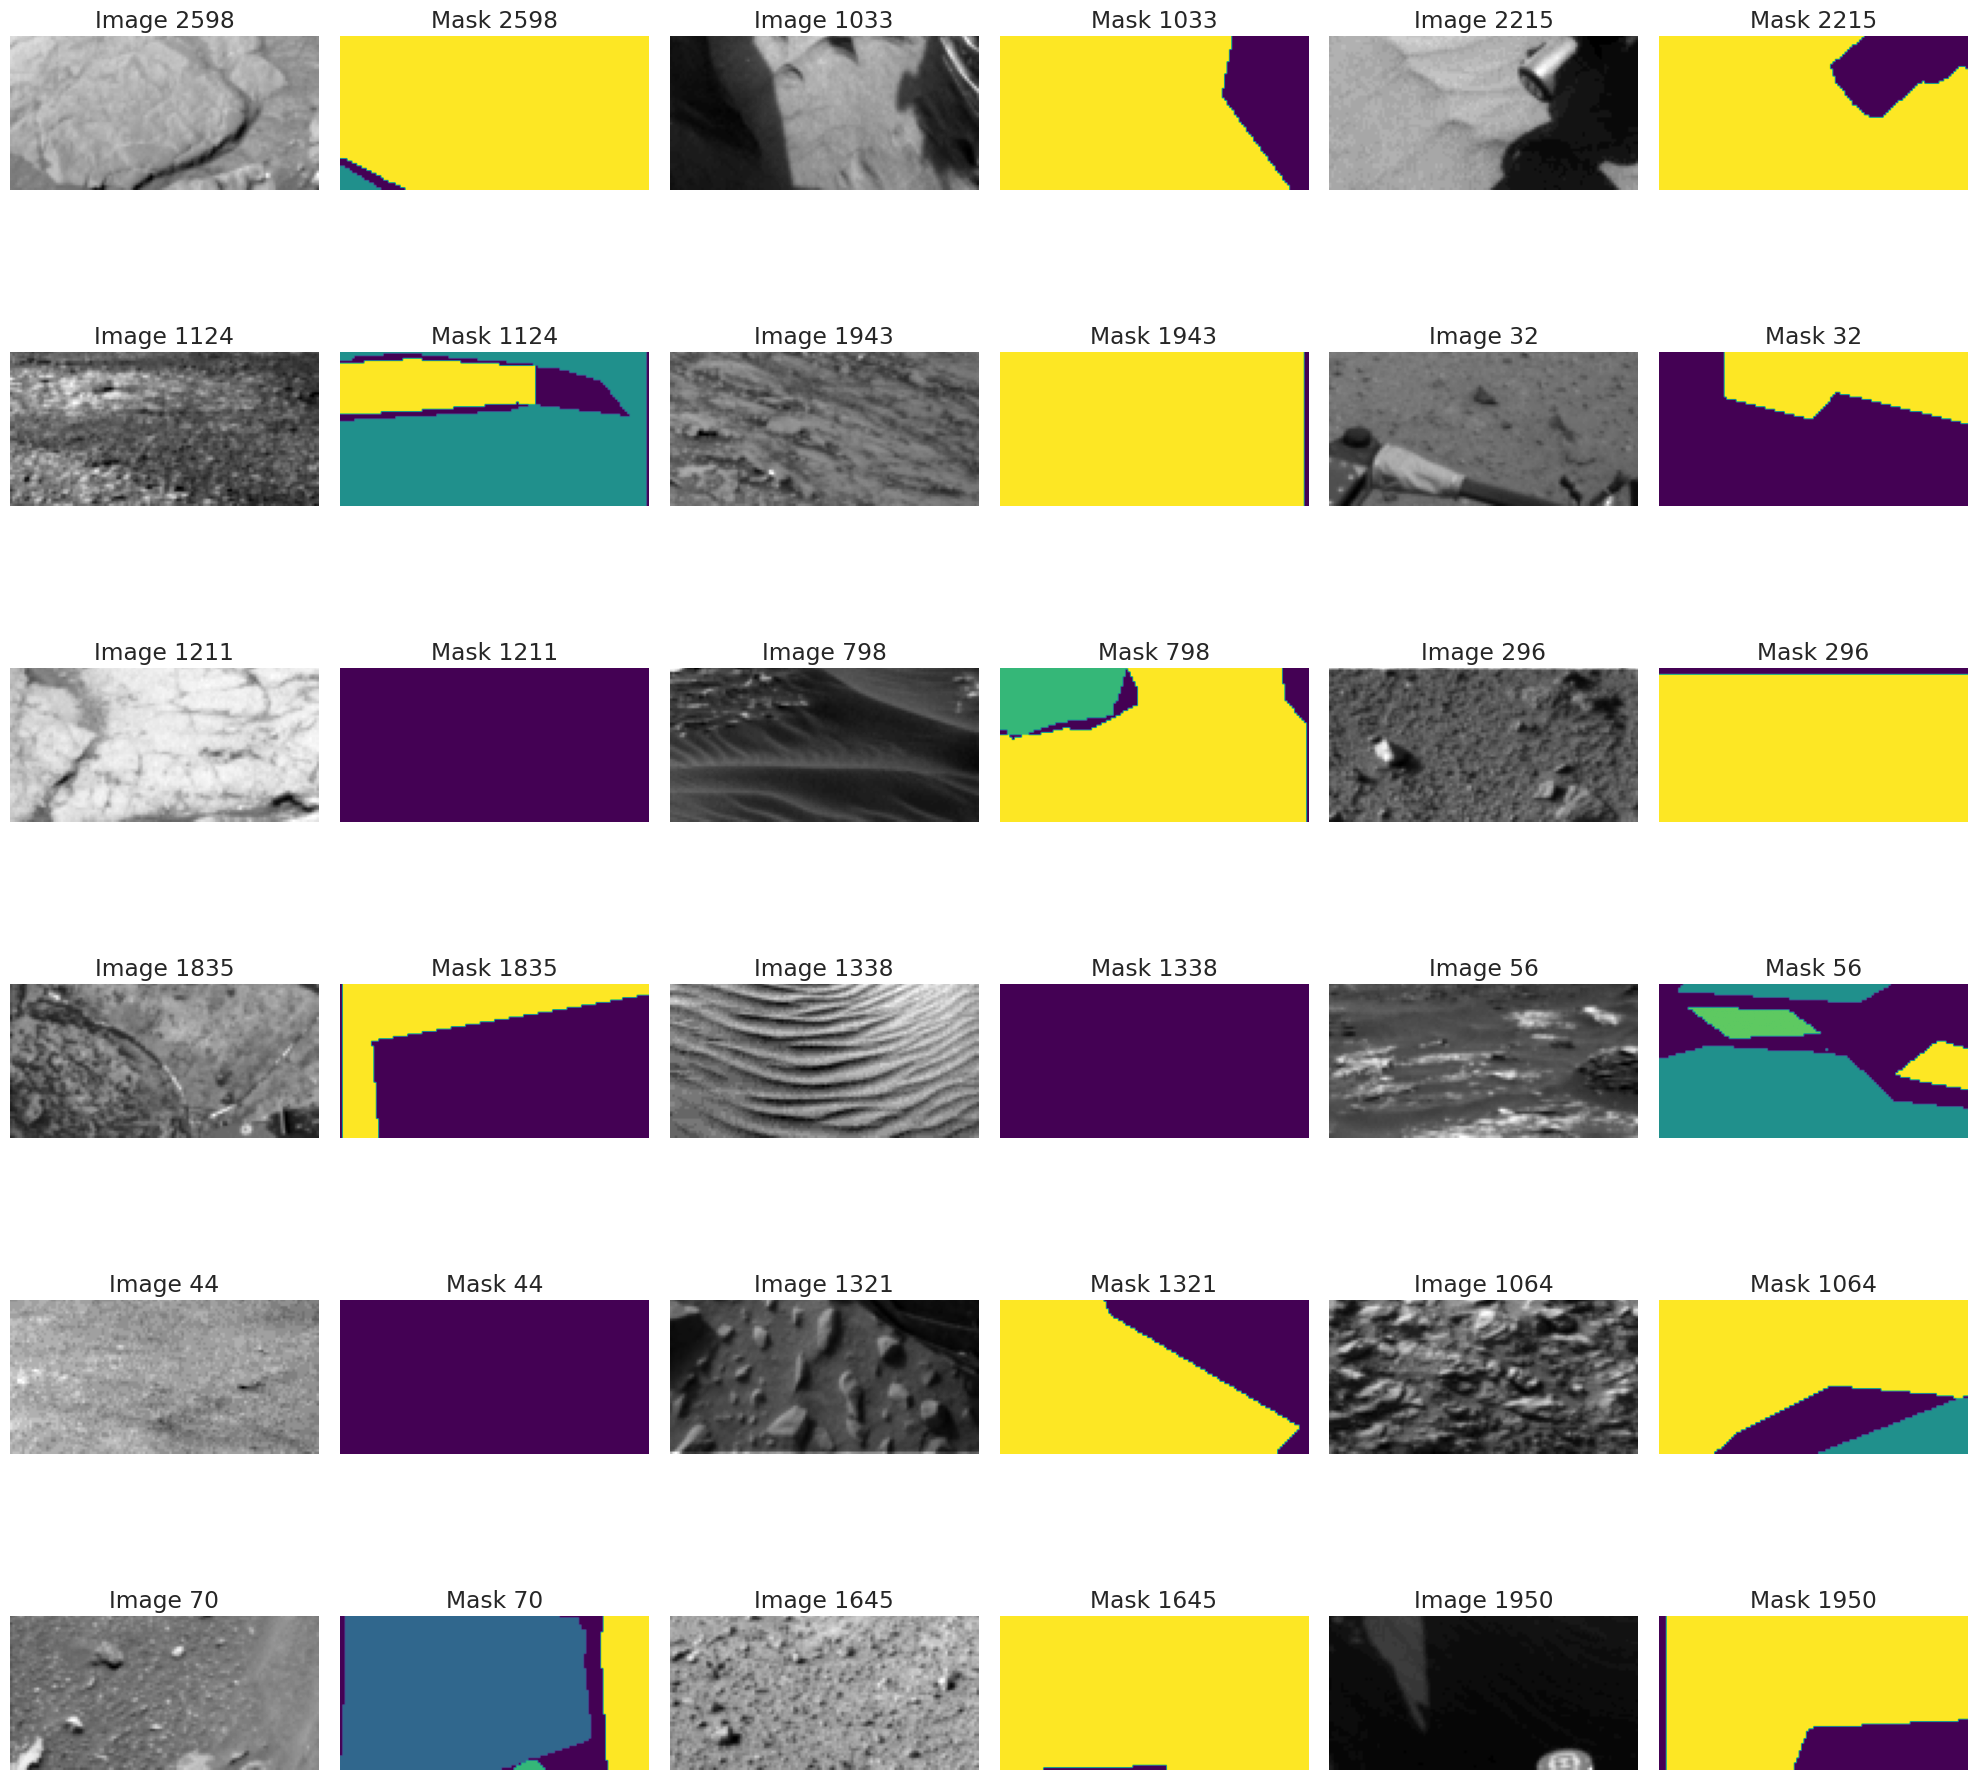

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot random images and their masks
def plot_random_images_with_masks(X_train, y_train, num_pairs=18):
    # Randomly select indices for the images and masks
    indices = np.random.choice(len(X_train), size=num_pairs, replace=False)

    # Create a grid layout for displaying images and masks
    plt.figure(figsize=(20, 20))  # Adjust size for better visibility

    for i, idx in enumerate(indices):
        # Display the grayscale Mars terrain image
        plt.subplot(6, 6, 2 * i + 1)  # Odd columns for images
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Display the segmentation mask
        plt.subplot(6, 6, 2 * i + 2)  # Even columns for masks
        plt.imshow(y_train[idx], cmap='viridis')  # Use a colormap to distinguish classes
        plt.title(f"Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot 25 random pairs of images and masks
plot_random_images_with_masks(X_train, y_train, num_pairs=18)

In [7]:
# Index of the type of image to remove
ET_index= 1082
ET_mask = y_train[ET_index]
count = 0

# Searching of the outsider
ET_to_remove = []

for i in range(len(y_train)):
    if np.array_equal(y_train[i], ET_mask):
        ET_to_remove.append(i)
        count = count+1


# Remove Alien
X= np.delete(X_train, ET_to_remove, axis=0)
y= np.delete(y_train, ET_to_remove, axis=0)
count

110

In [8]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.09, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=seed)

# Apply horizontal flip augmentation to the training set if specified
horizontal_flip = False

if horizontal_flip:
    X_train_flipped = np.flip(X_train, axis=2)
    X_train = np.concatenate([X_train, X_train_flipped], axis=0)
    y_train_flipped = np.flip(y_train, axis=2)
    y_train = np.concatenate([y_train, y_train_flipped], axis=0)

# Display the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2051, 64, 128),
 (2051, 64, 128),
 (228, 64, 128),
 (228, 64, 128),
 (226, 64, 128),
 (226, 64, 128))

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
test_set = X_test[..., np.newaxis] / 255.0

X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 8 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Print the results
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 1702 images (at least 8 pixels)
Class 1: present in 1016 images (at least 8 pixels)
Class 2: present in 958 images (at least 8 pixels)
Class 3: present in 703 images (at least 8 pixels)
Class 4: present in 51 images (at least 8 pixels)


In [11]:
# Find masks indexes with at least 8 pixels of class 4
class_4_indices = [i for i, label in enumerate(y_train) if tf.reduce_sum(tf.cast(label == 4, tf.int32)) >= 8]

# Get images and masks related to class 4
X_class_4 = X_train[class_4_indices]
y_class_4 = y_train[class_4_indices]

print(f"Samples with class 4: {len(X_class_4)}")


Samples with class 4: 51


In [12]:
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomZoom, RandomRotation

def augment_image4(image, label):
    # Add channel dimension if needed
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)

    # Concatenate image and label along channel dimension
    combined = tf.concat([image, label], axis=-1)  # Shape: (64, 128, 2)

    # Apply augmentations

    # Random Flip
    random_flip = RandomFlip(mode="horizontal")
    combined = random_flip(combined)

    # Random Translation
    random_translation = RandomTranslation(
        height_factor=(-0.1,0.1),
        width_factor=(-0.1, 0.1),
        fill_mode="nearest",  # fill pixels
        interpolation="bilinear"
    )
    combined = random_translation(combined)

    # Random Zoom
    random_zoom = RandomZoom(
        height_factor=(0.0, 0.1),
        width_factor=(0.0, 0.1),
        fill_mode="nearest",  # fill pixels
        interpolation="bilinear"
    )
    combined = random_zoom(combined)

    # Random rotation
    random_rotation = RandomRotation(factor=0.1,fill_mode="nearest", interpolation="bilinear")
    combined = random_rotation(combined)

    # separate image and label
    image = combined[..., 0:1]  # first channel
    label = combined[..., 1:2]  # Second channel

    # Adjustments for image (only brightness and contrast)
    delta = tf.random.uniform([], -0.1, 0.1)
    image = tf.image.adjust_brightness(image, delta)

    contrast_factor = tf.random.uniform([], 0.9, 1.1)
    image = tf.image.adjust_contrast(image, contrast_factor)

    # remove channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


In [13]:
def augment_class_4(X_class_4, y_class_4, target_factor=24):
    """
    Augment samples of class 4 until their number is increased by the target_factor.
    """
    augmented_X = []
    augmented_y = []

    num_original = len(X_class_4)
    total_target = num_original * target_factor

    # Calculate how many augmentations are needed
    current_total = num_original
    while current_total < total_target:
        for i in range(len(X_class_4)):
            img, mask = augment_image4(X_class_4[i], y_class_4[i])
            augmented_X.append(img)  
            augmented_y.append(mask)  
            current_total += 1
            if current_total >= total_target:
                break

    # Convert to NumPy arrays
    augmented_X = tf.stack(augmented_X).numpy()  
    augmented_y = tf.stack(augmented_y).numpy()  

    # Ensure the augmented data has the correct shape
    if len(augmented_X.shape) == 3:  # Se manca il canale
        augmented_X = np.expand_dims(augmented_X, axis=-1)

    return augmented_X, augmented_y

# Apply targeted oversampling and augmentation to class 4
augmented_X_class_4, augmented_y_class_4 = augment_class_4(X_class_4, y_class_4, target_factor=24)


In [14]:
# Concatenate the new samples with the training set
X_train = np.concatenate([X_train, augmented_X_class_4], axis=0)
y_train = np.concatenate([y_train, augmented_y_class_4], axis=0)

print(f"New number of samples in the training set: {X_train.shape[0]}")

New number of samples in the training set: 3224


In [15]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 10 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Print the results
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 2873 images (at least 8 pixels)
Class 1: present in 1436 images (at least 8 pixels)
Class 2: present in 1596 images (at least 8 pixels)
Class 3: present in 1456 images (at least 8 pixels)
Class 4: present in 974 images (at least 8 pixels)


In [16]:
# Set batch size for training
batch_size = 128

# Set learning rate for the optimiser
learning_rate = 4e-4

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 200


In [17]:
# Residual Block
def residual_block(x, filters, name, dropout_rate=0.1):
    shortcut = x
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=f'{name}_conv1')(x)
    x = tfkl.GroupNormalization(name=f'{name}_bn1')(x)
    x = tfkl.ReLU(name=f'{name}_relu1')(x)
    x = tfkl.Dropout(dropout_rate, name=f'{name}_dropout1')(x)
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=f'{name}_conv2')(x)
    x = tfkl.GroupNormalization(name=f'{name}_bn2')(x)

    # Add shortcut
    shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}_shortcut')(shortcut)
    x = tfkl.Add(name=f'{name}_add')([x, shortcut])
    return tfkl.ReLU(name=f'{name}_relu2')(x)

# Squeeze-and-Excite Block
def squeeze_excite_block(x, reduction=16, name="SE"):
    filters = x.shape[-1]
    se = tfkl.GlobalAveragePooling2D(name=f'{name}_gap')(x)
    se = tfkl.Dense(filters // reduction, activation='relu', name=f'{name}_fc1')(se)
    se = tfkl.Dense(filters, activation='sigmoid', name=f'{name}_fc2')(se)
    se = tfkl.Reshape((1, 1, filters), name=f'{name}_reshape')(se)
    return tfkl.Multiply(name=f'{name}_multiply')([x, se])

def aspp_block(x, filters, name="ASPP"):
    atrous_1 = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}_atrous1')(x)
    atrous_6 = tfkl.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=6, name=f'{name}_atrous6')(x)
    atrous_12 = tfkl.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=12, name=f'{name}_atrous12')(x)
    atrous_18 = tfkl.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=18, name=f'{name}_atrous18')(x)

    # Global Average Pooling
    global_pool = tfkl.GlobalAveragePooling2D(name=f'{name}_gap')(x)
    global_pool = tfkl.Reshape((1, 1, x.shape[-1]), name=f'{name}_reshape')(global_pool)
    global_pool = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}_global')(global_pool)

    # Infer symbolic dimensions of `x` for upsampling
    input_shape = tf.keras.backend.int_shape(x)
    height, width = input_shape[1], input_shape[2]
    if height is not None and width is not None:
        global_pool = tfkl.UpSampling2D(size=(height, width), interpolation='bilinear', name=f'{name}_upsample')(global_pool)
    else:
        raise ValueError(f"Input dimensions are dynamic, unable to compute spatial dimensions for {name}")

    # Concatenate
    x = tfkl.Concatenate(name=f'{name}_concat')([atrous_1, atrous_6, atrous_12, atrous_18, global_pool])
    return tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}_conv')(x)

# Encoder Block
def encoder_block(x, filters, name, pool_size=(2, 2)):
    x = residual_block(x, filters, name=name)
    se = squeeze_excite_block(x, name=f'{name}_SE')
    p = tfkl.MaxPooling2D(pool_size=pool_size, name=f'{name}_pool')(se)
    return se, p

# Decoder Block with dimension alignment
def decoder_block(x, skip, filters, name, upsample_size=(2, 2)):
    #bottleneck upsample
    x = tfkl.UpSampling2D(size=upsample_size, interpolation='bilinear', name=f'{name}_upsample')(x)
    
    #skip connection dimension alignment
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        skip = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name=f'{name}_skip_upsample')(skip)
    
    # Concatenation
    x = tfkl.Concatenate(name=f'{name}_concat')([x, skip])
    
    # Residual block
    x = residual_block(x, filters, name=name)
    return x

In [18]:
def double_unet(input_shape=(64, 128, 1), num_classes=5):
    inputs = tfkl.Input(shape=input_shape, name="input_layer")

    # First Network
    e1, p1 = encoder_block(inputs, 32, name='enc1_1')
    e2, p2 = encoder_block(p1, 64, name='enc1_2')
    e3, p3 = encoder_block(p2, 128, name='enc1_3')
    e4, p4 = encoder_block(p3, 256, name='enc1_4')
    
    bottleneck1 = aspp_block(p4, 512, name='aspp1')
    
    d4 = decoder_block(bottleneck1, e4, 256, name='dec1_4')
    d3 = decoder_block(d4, e3, 128, name='dec1_3')
    d2 = decoder_block(d3, e2, 64, name='dec1_2')
    d1 = decoder_block(d2, e1, 32, name='dec1_1')
    output1 = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax', name='output1')(d1)
    
    # Second Network
    multiplied_input = tfkl.Multiply(name='multiply_input')([inputs, output1])
    
    e1_2, p1_2 = encoder_block(multiplied_input, 32, name='enc2_1')
    e2_2 = encoder_block(p1_2, 64, name='enc2_2')[1]
    e3_2 = encoder_block(e2_2, 128, name='enc2_3')[1]
    e4_2 = encoder_block(e3_2, 256, name='enc2_4')[1]
    
    bottleneck2 = aspp_block(e4_2, 512, name='aspp2')
    
    d4_2 = decoder_block(bottleneck2, e4_2, 256, name='dec2_4')
    d3_2 = decoder_block(d4_2, e3_2, 128, name='dec2_3')
    d2_2 = decoder_block(d3_2, e2_2, 64, name='dec2_2')
    d1_2 = decoder_block(d2_2, e1_2, 32, name='dec2_1')
    
    output2 = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax', name='output2')(d1_2)
    
    return tf.keras.Model(inputs, output2, name="DoubleU-Net")

Model: "DoubleU-Net"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_conv1      │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_bn1        │ (None, 64, 128, │        64 │ enc1_1_conv1[… │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_relu1      │ (None, 64, 128, │         0 │ enc1_1_bn1[0]… │   -   │
│ (ReLU)            │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_dropout1   │ (None, 64, 128, │         0 │ enc1_1_relu1[… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_conv2      │ (None, 64, 128, │     9,248 │ enc1_1_dropou… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_bn2        │ (None, 64, 128, │        64 │ enc1_1_conv2[… │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_shortcut   │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_add (Add)  │ (None, 64, 128, │         0 │ enc1_1_bn2[0]… │   -   │
│                   │ 32)             │           │ enc1_1_shortc… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_relu2      │ (None, 64, 128, │         0 │ enc1_1_add[0]… │   -   │
│ (ReLU)            │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_SE_gap     │ (None, 32)      │         0 │ enc1_1_relu2[… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_SE_fc1     │ (None, 2)       │        66 │ enc1_1_SE_gap… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_SE_fc2     │ (None, 32)      │        96 │ enc1_1_SE_fc1… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_SE_reshape │ (None, 1, 1,    │         0 │ enc1_1_SE_fc2… │   -   │
│ (Reshape)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_SE_multip… │ (None, 64, 128, │         0 │ enc1_1_relu2[… │   -   │
│ (Multiply)        │ 32)             │           │ enc1_1_SE_res… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_pool       │ (None, 32, 64,  │         0 │ enc1_1_SE_mul… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_conv1      │ (None, 32, 64,  │    18,496 │ enc1_1_pool[0… │   Y 

 Total params: 19,484,230 (74.33 MB)

 Trainable params: 19,484,230 (74.33 MB)

 Non-trainable params: 0 (0.00 B)

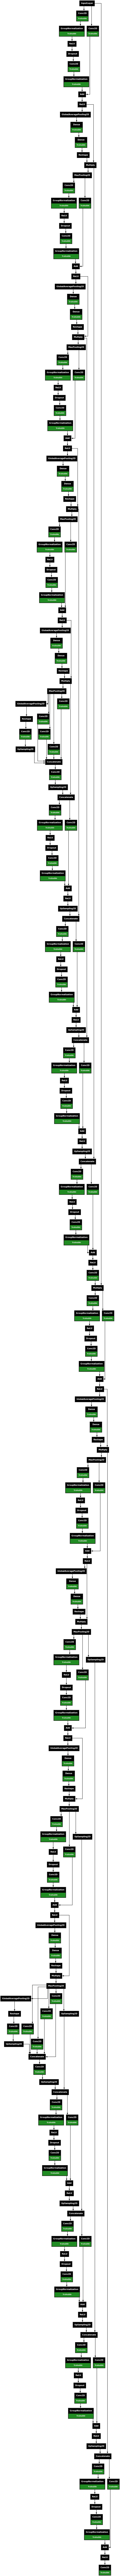

In [19]:
model = double_unet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## 🛠️ Train and Save the Model

In [20]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [21]:
import tensorflow.keras.backend as K
class_indexes = tf.range(1, 5)  # Indici da 1 a 4
def _gather_channels(x, indexes=class_indexes, **kwargs):
    """Slice tensor along channels axis by given indexes."""
    backend = kwargs.get('backend', K)
    x = backend.permute_dimensions(x, (3, 0, 1, 2))  # Sposta i canali in prima posizione
    x = backend.gather(x, indexes)  # Seleziona i canali specificati
    x = backend.permute_dimensions(x, (1, 2, 3, 0))  # Riporta i canali all'ultima posizione
    return x

def stable_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Numerically stable focal loss for multi-class segmentation, ignoring class 0."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Check if y_true is one-hot encoded, or change it
    if len(y_true.shape) < len(y_pred.shape):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

    # exclude class 0
    y_true = _gather_channels(y_true, indexes=class_indexes, backend=K)
    y_pred = _gather_channels(y_pred, indexes=class_indexes, backend=K)

    # Clip values for numerical stability
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # Compute Focal Loss
    loss = -y_true * (alpha * K.pow(1.0 - y_pred, gamma) * K.log(y_pred))

    return K.mean(loss)

In [22]:
def gather_channels(*xs, indexes=class_indexes, backend):
    """Select specified tensor channels."""
    if indexes is None:
        return xs
    elif isinstance(indexes, int):
        indexes = [indexes]
    xs = [tf.gather(x, indexes, axis=-1) for x in xs]
    return xs

def get_reduce_axes(per_image, backend):
    """Return reduced axes."""
    axes = [1, 2]  # for images (B, H, W, C)
    if not per_image:
        axes.insert(0, 0)  
    return axes

def average(x, per_image=False, class_weights=None, backend=None):
    """Applica la media a un tensore."""
    if per_image:
        x = backend.mean(x, axis=0)  # image mean
    if class_weights is not None:
        x = x * class_weights  # Apply class weights
    return backend.mean(x)

def f_score(y_true, y_pred, beta=1, class_weights=1, class_indexes=class_indexes, smooth=1e-7, per_image=False, threshold=None, **kwargs):
    """
    Compute F-Score for multi-class segmentation.

    Args:
        y_true: Ground truth tensor (B, H, W, C) o (B, H, W).
        y_pred: Predizioni tensor (B, H, W, C).
        beta: Coefficient to bilance precision and recall.
        class_weights: class weights (array/list).
        class_indexes: List of classes to consider, None for all of them.
        smooth: smoothing coefficient for numerical stability.
        per_image: Compute for immage or batch.
        threshold: to binarize predictions, None to keep original values.

    Returns:
        F-score as a scalar.
    """
    backend = tf.keras.backend

    # input tensor check
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    if len(y_true.shape) == 3:  # Convert y_true into one-hot encoding
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    y_true, y_pred = gather_channels(y_true, y_pred, indexes=class_indexes, backend=backend)
    if threshold is not None:  
        y_pred = tf.cast(y_pred > threshold, tf.float32)

    axes = get_reduce_axes(per_image, backend=backend)

    # Compute true positive, false positive and false negative
    tp = backend.sum(y_true * y_pred, axis=axes)
    fp = backend.sum(y_pred, axis=axes) - tp
    fn = backend.sum(y_true, axis=axes) - tp

    # F-score formula
    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image=per_image, class_weights=class_weights, backend=backend)

    return score

class DiceLoss(tf.keras.losses.Loss):
    """
    Dice Loss implementation.

    Args:
        beta: Coefficient to bilance precision and recall.
        class_weights: class weights (array/list).
        class_indexes: List of classes to consider, None for all of them.
        smooth: smoothing coefficient for numerical stability.
        per_image: Compute for immage or batch.
    """
    def __init__(self, beta=1, class_weights=None, class_indexes=class_indexes, per_image=False, smooth=1e-7):
        super().__init__(name="dice_loss")
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.per_image = per_image
        self.smooth = smooth

    def call(self, y_true, y_pred):
        return 1 - f_score(
            y_true, y_pred,
            beta=self.beta,
            class_weights=self.class_weights,
            class_indexes=class_indexes,
            smooth=self.smooth,
            per_image=self.per_image,
        )


In [23]:
class WeightedDiceFocalLoss(tf.keras.losses.Loss):
    """
    Combine Dice Loss and Focal Loss witrh custom weights.

    Args:
        f: Focal Loss weight.
        d: Dice Loss weight.
        gamma:Focal Loss parameter (for difficult samples).
        alpha: weight for simple classes in Focal Loss.
        beta: Coefficient to bilance precision and recall.
        class_indexes: List of classes to consider, None for all of them.
        smooth: smoothing coefficient for numerical stability.
    """
    def __init__(self, f=1, d=1, gamma=2.0, alpha=0.25, beta=1, smooth=1e-7, class_indexes=class_indexes):
        super().__init__(name="weighted_dice_focal_loss")
        self.f = f
        self.d = d
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.class_indexes = class_indexes
        self.dice_loss = DiceLoss(beta=beta, smooth=smooth, class_indexes=class_indexes)

    def call(self, y_true, y_pred):
        # Compute Dice Loss
        dice_loss = self.dice_loss(y_true, y_pred)

        # Compute Focal Loss
        focal_loss = stable_focal_loss(
            y_true, y_pred, 
            gamma=self.gamma, 
            alpha=self.alpha
        )

        # Combine weighted losses
        combined_loss = self.f * focal_loss + self.d * dice_loss
        return combined_loss


Epoch 1/200


I0000 00:00:1734186937.532803    1868 service.cc:145] XLA service 0x599550f58f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734186937.532850    1868 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734186937.532853    1868 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734187094.476958    1868 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 - 340s - 13s/step - accuracy: 0.2169 - loss: 0.0981 - mean_iou: 0.1237 - val_accuracy: 0.3807 - val_loss: 0.0341 - val_mean_iou: 0.1871 - learning_rate: 4.0000e-04
Epoch 2/200
26/26 - 43s - 2s/step - accuracy: 0.2887 - loss: 0.0274 - mean_iou: 0.1709 - val_accuracy: 0.4525 - val_loss: 0.0246 - val_mean_iou: 0.2862 - learning_rate: 4.0000e-04
Epoch 3/200
26/26 - 42s - 2s/step - accuracy: 0.3246 - loss: 0.0233 - mean_iou: 0.1938 - val_accuracy: 0.4756 - val_loss: 0.0221 - val_mean_iou: 0.3020 - learning_rate: 4.0000e-04
Epoch 4/200
26/26 - 42s - 2s/step - accuracy: 0.3497 - loss: 0.0219 - mean_iou: 0.2133 - val_accuracy: 0.5091 - val_loss: 0.0217 - val_mean_iou: 0.3600 - learning_rate: 4.0000e-04
Epoch 5/200
26/26 - 42s - 2s/step - accuracy: 0.3642 - loss: 0.0211 - mean_iou: 0.2266 - val_accuracy: 0.5211 - val_loss: 0.0196 - val_mean_iou: 0.3706 - learning_rate: 4.0000e-04
Epoch 6/200
26/26 - 42s - 2s/step - accuracy: 0.3898 - loss: 0.0195 - mean_iou: 0.2493 - val_accuracy: 0.5228 

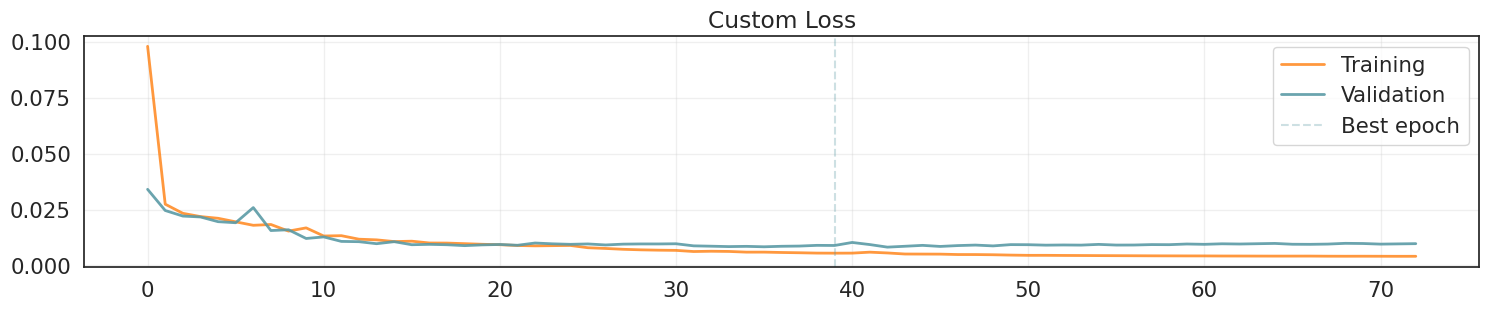

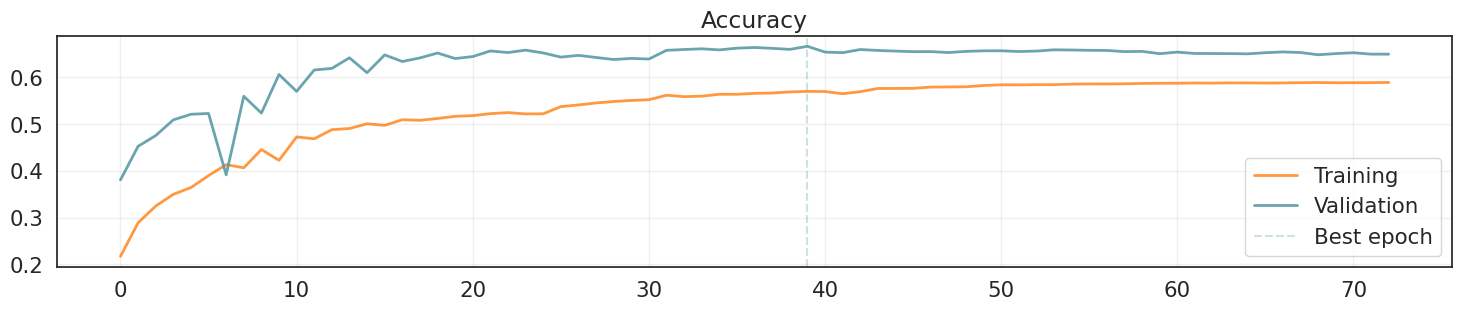

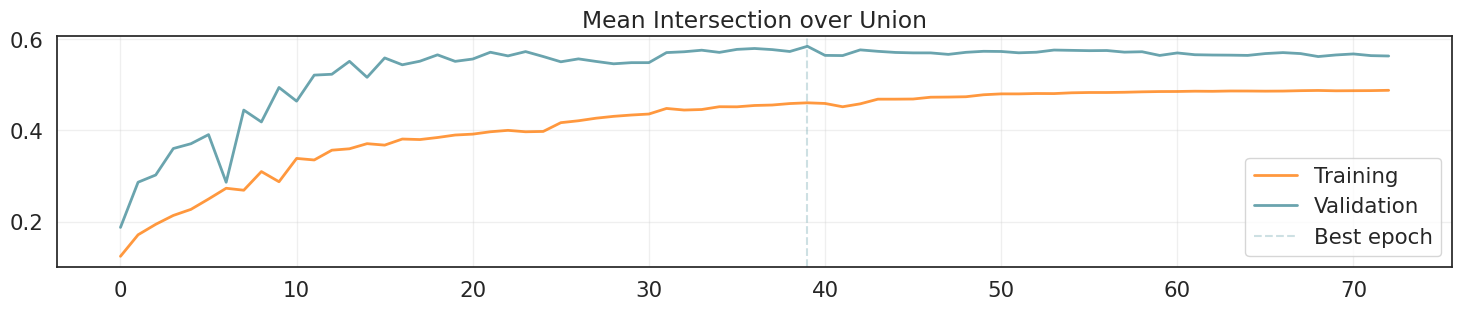

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=4e-4),
    loss=stable_focal_loss,
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)
]

history = model.fit(
    x=X_train*255.0,
    y=y_train,
    validation_data=(X_val*255.0, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)


best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Custom Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [25]:
print(f"X_test shape: {test_set.shape}")
print(f"y_test shape: {y_test.shape}")

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_set*255.0, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

X_test shape: (226, 64, 128, 1)
y_test shape: (226, 64, 128)
Test Accuracy: 0.6716
Test Mean Intersection over Union: 0.5879


In [26]:
model_filename = "model_silvia.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_silvia.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [27]:
x_test_ev = x_test_ev[..., np.newaxis]

In [28]:
preds = model.predict(x_test_ev)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 51s 128ms/step
Predictions shape: (10022, 64, 128)


In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```